In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openml

plt.style.use('ggplot')

#random_state
rs = 321

# Trabalho de Aprendizagem de Máquina I (PES Embraer)
Alunos: Caio Costa e Jonas Rodrigues

**Do Classroom:**

Seguem algumas instruções para realizar os experimentos:

- selecionar um banco de dados do OpenML (https://www.openml.org/)
    - o banco de dados de classificação deve ter: > 3 classes, >10 atributos e >1000 instâncias
    - cada dupla deve informar qual banco de dados usará com antecedência
- 10-fold cross-validation
- avaliar máquinas de aprendizagem: kNN, DT, MLP, NB, SVM, … 
- métricas (area under the ROC curve, f1-score, accuracy, matriz de confusão média)
- para ajustar os parâmetros das máquinas de aprendizagem usar grid-search ou escolher os parâmetros e justificar

O relatório final deve conter pelo menos as seguintes informações:
1. Introdução
2. Algoritmos de Aprendizagem de Máquina
3. Experimentos  
    3.1. Banco de dados  
    3.2. Métricas  
    3.3. Resultados   
4. Conclusões
5. Referências

In [2]:
data = openml\
        .datasets\
        .get_dataset(46, download_data=True, download_qualities=True, download_features_meta_data=True)

df = data.get_data()[0]

In [3]:
data

OpenML Dataset
Name..........: splice
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:22:49
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/46/splice.arff
OpenML URL....: https://www.openml.org/d/46
# of features.: 61
# of instances: 3190

In [4]:
df.head()

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,...,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60,Class
0,C,C,A,G,C,T,G,C,A,T,...,G,C,C,A,G,T,C,T,G,EI
1,A,G,A,C,C,C,G,C,C,G,...,T,G,C,C,C,C,C,G,C,EI
2,G,A,G,G,T,G,A,A,G,G,...,A,C,G,G,G,G,A,T,G,EI
3,G,G,G,C,T,G,C,G,T,T,...,G,T,T,T,T,C,C,C,C,EI
4,G,C,T,C,A,G,C,C,C,C,...,C,T,T,G,A,C,C,C,T,EI


In [5]:
#contagem das bases
cols = df.iloc[:,:-1]
cols.melt()['value'].value_counts()

C    50300
G    50245
T    46308
A    44487
N       56
D        2
R        1
S        1
Name: value, dtype: int64

In [6]:
#verificação de quantas instâncias possuem as bases ambíguas (N, D, R, S)

#instâncias que contém N, D, R ou S entre as features
idx_ndrs = df.iloc[:,:-1]\
             .isin(["N", "D", "R", "S"])\
             .any(axis=1) 

print(f"Existem {len(df[idx_ndrs])} linhas com bases ambíguas (N, D, R ou S).")

Existem 15 linhas com bases ambíguas (N, D, R ou S).


# Avaliação das classes target

In [7]:
df['Class'].value_counts()

N     1655
IE     768
EI     767
Name: Class, dtype: int64

<Axes: >

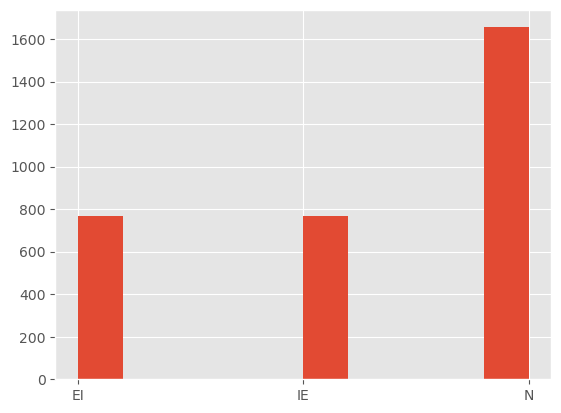

In [8]:
df['Class'].hist()

# Preparo do dataset

In [9]:
#remoção das instâncias com bases ambíguas

df = df[~idx_ndrs]

In [10]:
#converter colunas para categorical
for col in df.columns:
    df[col] = df[col].cat.remove_unused_categories()

# Encoding das features e targets

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

F = df.columns[:-1].to_list()
T = df.columns[-1]

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), F),
    ('oe', OrdinalEncoder(), [T]) #para este caso, LabelEncoder == OrdinalEncoder
])

In [12]:
encoded = ct.fit_transform(df).toarray()

# Divisão treino-teste
80% treino, 20% teste

In [13]:
from sklearn.model_selection import train_test_split

X = encoded[:, :-1]
y = encoded[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

In [14]:
# nessa parte, é necessário estratificar? As classes já parecem razoavelmente distribuídas

In [15]:
pd.Series(y_train).value_counts(normalize=True)

2.0    0.516929
1.0    0.243307
0.0    0.239764
dtype: float64

In [16]:
pd.Series(y_test).value_counts(normalize=True)

2.0    0.527559
0.0    0.240945
1.0    0.231496
dtype: float64

In [17]:
#one-hot encoding ou label encoding?
# encoded = pd.get_dummies(df, drop_first=True)
# encoded

# FEATURES = encoded.columns[:-2]
# TARGETS = encoded.columns[-2:]

# X = encoded[FEATURES]
# y = encoded[TARGETS]

# Classificadores
- kNN, DT, MLP, NB, SVM

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

In [19]:
estimators = {'knn': KNeighborsClassifier(), 
              'dt': DecisionTreeClassifier(),
              'mlp': MLPClassifier(),
              'nb': BernoulliNB(),
              'svm': SVC()}

In [20]:
#listagem de hiperparâmetros

for a, b in estimators.items():
    print("Parâmetros para {}: \n{}\n".format(b, b.get_params()))

Parâmetros para KNeighborsClassifier(): 
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}

Parâmetros para DecisionTreeClassifier(): 
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

Parâmetros para MLPClassifier(): 
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbos

In [43]:
#parâmetros para busca

param_grid = {
    
    'knn': {
        'n_neighbors': [5, 7, 9, 11, 13, 15, 17, 19, 20, 30, 40, 50]
    },
    
    'dt': {
        'criterion': ["gini", "entropy"],
        'min_samples_leaf': [1, 2, 3]
    },
    
    'mlp': {
        'alpha': [0.01, 0.05, 0.1, 0.2]
    },
    
    'nb': {
        'alpha': [0.001, 0.01, 0.1, 1, 2, 10]
    },

    'svm': [{
        'C': [1, 2, 5, 10],
        'kernel': ['linear', 'rbf']
    },
        {
        'C': [1, 2, 5, 10],
        'kernel': ['poly'],
        'degree': [2, 3]
    }]

}


# 10-fold stratified cross-validation

In [22]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=rs)

# Grid Search CV
- Randomized Search CV?

In [23]:
import mlflow
import mlflow.sklearn

from sklearn.metrics import f1_score, accuracy_score

In [24]:
!start /b mlflow ui

In [25]:
# def eval_metrics(actual, pred):
    
#     f1 = f1_score(actual, pred, average=None)
#     acc = accuracy_score(actual, pred)
    
#     return f1, acc

In [34]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [26]:
mlflow.sklearn.autolog()

In [56]:
from sklearn.model_selection import GridSearchCV

results = {}
results2 = {}

for est in estimators:
    
    est_name = str(estimators[est])
    est_est = estimators[est]
    est_params = param_grid[est]
    
    mlflow.start_run()
    mlflow.set_tag('estimator', est_name)
    
    print(f"Executando {est_name}...")
    
    grid = GridSearchCV(estimator = est_est,
                        param_grid = est_params,
                        scoring = 'accuracy',
                        cv = cv,
                        verbose=2,
                        n_jobs=-1)
    
    grid.fit(X_train, y_train)
    results[est] = grid.cv_results_
    
    #predição
    y_pred = grid.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)
    
    results2[est] = [f1, acc]
    
    mlflow.log_metric('test_f1_score', f1)
    mlflow.log_metric('test_acc_score', acc)
    
    mlflow.end_run()

Executando KNeighborsClassifier()...
Fitting 10 folds for each of 12 candidates, totalling 120 fits


2023/07/26 00:40:05 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.


Executando DecisionTreeClassifier()...
Fitting 10 folds for each of 6 candidates, totalling 60 fits


2023/07/26 00:40:11 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


Executando MLPClassifier()...
Fitting 10 folds for each of 4 candidates, totalling 40 fits


2023/07/26 00:40:40 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Executando BernoulliNB()...
Fitting 10 folds for each of 6 candidates, totalling 60 fits


2023/07/26 00:40:47 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


Executando SVC()...
Fitting 10 folds for each of 16 candidates, totalling 160 fits


2023/07/26 00:41:09 INFO mlflow.sklearn.utils: Logging the 5 best runs, 11 runs will be omitted.


In [64]:
results.keys()

dict_keys(['knn', 'dt', 'mlp', 'nb', 'svm'])

In [65]:
pd.DataFrame(results['knn'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003900,0.000538,0.037900,0.002548,5,{'n_neighbors': 5},0.775591,0.767717,0.807087,0.748031,0.744094,0.771654,0.748031,0.791339,0.775591,0.803150,0.773228,0.021289,12
1,0.004400,0.000917,0.038601,0.003136,7,{'n_neighbors': 7},0.811024,0.791339,0.814961,0.775591,0.791339,0.811024,0.771654,0.811024,0.783465,0.846457,0.800787,0.021362,11
2,0.004300,0.000640,0.038799,0.004601,9,{'n_neighbors': 9},0.834646,0.811024,0.846457,0.787402,0.799213,0.842520,0.783465,0.814961,0.791339,0.854331,0.816535,0.024974,10
3,0.003600,0.000663,0.037100,0.002022,11,{'n_neighbors': 11},0.826772,0.854331,0.866142,0.799213,0.822835,0.830709,0.803150,0.838583,0.822835,0.850394,0.831496,0.020366,9
4,0.003601,0.000800,0.037699,0.003823,13,{'n_neighbors': 13},0.846457,0.838583,0.858268,0.799213,0.818898,0.838583,0.811024,0.842520,0.822835,0.854331,0.833071,0.018314,8
5,0.003301,0.000781,0.036300,0.003578,15,{'n_neighbors': 15},0.846457,0.846457,0.866142,0.818898,0.826772,0.826772,0.826772,0.846457,0.822835,0.834646,0.836220,0.013997,7
6,0.003401,0.000664,0.036500,0.001629,17,{'n_neighbors': 17},0.834646,0.862205,0.877953,0.787402,0.838583,0.862205,0.818898,0.850394,0.846457,0.846457,0.842520,0.024077,6
7,0.003500,0.000670,0.037401,0.002059,19,{'n_neighbors': 19},0.818898,0.881890,0.893701,0.822835,0.834646,0.858268,0.838583,0.854331,0.842520,0.854331,0.850000,0.022716,5
8,0.003501,0.000923,0.038599,0.001854,20,{'n_neighbors': 20},0.838583,0.877953,0.893701,0.818898,0.846457,0.866142,0.834646,0.850394,0.850394,0.885827,0.856299,0.022770,4
9,0.003701,0.000639,0.037399,0.003106,30,{'n_neighbors': 30},0.838583,0.889764,0.889764,0.822835,0.870079,0.870079,0.862205,0.866142,0.850394,0.854331,0.861417,0.019904,3


In [66]:
pd.DataFrame(results['dt'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.039399,0.001959,0.001001,0.000002,gini,1,"{'criterion': 'gini', 'min_samples_leaf': 1}",0.937008,0.948819,0.929134,0.913386,0.929134,0.929134,0.921260,0.933071,0.929134,0.940945,0.931102,0.009358,4
1,0.038799,0.002135,0.001100,0.000301,gini,2,"{'criterion': 'gini', 'min_samples_leaf': 2}",0.933071,0.921260,0.968504,0.929134,0.917323,0.944882,0.929134,0.929134,0.937008,0.956693,0.936614,0.015090,1
2,0.040302,0.003436,0.001199,0.000400,gini,3,"{'criterion': 'gini', 'min_samples_leaf': 3}",0.948819,0.929134,0.968504,0.917323,0.917323,0.940945,0.917323,0.929134,0.940945,0.956693,0.936614,0.016837,1
3,0.042601,0.005239,0.001100,0.000300,entropy,1,"{'criterion': 'entropy', 'min_samples_leaf': 1}",0.944882,0.921260,0.940945,0.933071,0.909449,0.933071,0.937008,0.940945,0.913386,0.921260,0.929528,0.011739,6
4,0.046200,0.011142,0.001400,0.000491,entropy,2,"{'criterion': 'entropy', 'min_samples_leaf': 2}",0.960630,0.921260,0.937008,0.913386,0.921260,0.933071,0.917323,0.929134,0.929134,0.937008,0.929921,0.012794,5
5,0.040099,0.005717,0.000700,0.000458,entropy,3,"{'criterion': 'entropy', 'min_samples_leaf': 3}",0.948819,0.933071,0.948819,0.909449,0.909449,0.933071,0.913386,0.929134,0.940945,0.944882,0.931102,0.014757,3


In [67]:
pd.DataFrame(results['mlp'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,4.438607,0.935020,0.002401,0.000487,0.01,{'alpha': 0.01},0.968504,0.948819,0.972441,0.933071,0.940945,0.948819,0.948819,0.948819,0.940945,0.960630,0.951181,0.011837,3
1,7.114309,0.250929,0.002798,0.000399,0.05,{'alpha': 0.05},0.968504,0.948819,0.968504,0.929134,0.937008,0.944882,0.956693,0.944882,0.944882,0.960630,0.950394,0.012350,4
2,6.754302,0.203523,0.002501,0.000671,0.1,{'alpha': 0.1},0.964567,0.956693,0.968504,0.944882,0.929134,0.944882,0.956693,0.956693,0.944882,0.964567,0.953150,0.011471,1
3,4.587991,1.339471,0.001400,0.000662,0.2,{'alpha': 0.2},0.956693,0.960630,0.980315,0.929134,0.944882,0.948819,0.956693,0.952756,0.937008,0.960630,0.952756,0.013409,2


In [68]:
pd.DataFrame(results['nb'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013501,0.001026,0.001699,0.000457,0.001,{'alpha': 0.001},0.96063,0.964567,0.972441,0.964567,0.940945,0.952756,0.972441,0.952756,0.921260,0.96063,0.956299,0.014778,1
1,0.015402,0.002245,0.001500,0.000499,0.01,{'alpha': 0.01},0.96063,0.964567,0.972441,0.964567,0.940945,0.952756,0.972441,0.952756,0.921260,0.96063,0.956299,0.014778,1
2,0.015801,0.002961,0.001901,0.000700,0.1,{'alpha': 0.1},0.96063,0.964567,0.972441,0.964567,0.940945,0.952756,0.972441,0.952756,0.921260,0.96063,0.956299,0.014778,1
3,0.021803,0.003515,0.002599,0.000664,1,{'alpha': 1},0.96063,0.964567,0.972441,0.964567,0.940945,0.952756,0.972441,0.952756,0.917323,0.96063,0.955906,0.015728,5
4,0.022301,0.002099,0.002300,0.000460,2,{'alpha': 2},0.96063,0.960630,0.972441,0.956693,0.944882,0.952756,0.976378,0.956693,0.921260,0.96063,0.956299,0.014460,1
5,0.014598,0.003292,0.001800,0.000399,10,{'alpha': 10},0.96063,0.956693,0.976378,0.944882,0.940945,0.948819,0.968504,0.956693,0.925197,0.96063,0.953937,0.013869,6


In [69]:
pd.DataFrame(results['svm'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_degree,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.391912,0.034730,0.011798,0.001326,1,linear,NaN,"{'C': 1, 'kernel': 'linear'}",0.944882,0.929134,...,0.921260,0.893701,0.925197,0.905512,0.929134,0.940945,0.937008,0.927559,0.016441,13
1,1.058313,0.076842,0.144095,0.032094,1,rbf,NaN,"{'C': 1, 'kernel': 'rbf'}",0.968504,0.972441,...,0.948819,0.944882,0.956693,0.972441,0.964567,0.960630,0.976378,0.964961,0.011739,9
2,0.364404,0.078485,0.018300,0.011567,2,linear,NaN,"{'C': 2, 'kernel': 'linear'}",0.940945,0.925197,...,0.909449,0.893701,0.929134,0.909449,0.933071,0.940945,0.925197,0.925197,0.015649,14
3,0.929710,0.107900,0.136094,0.014506,2,rbf,NaN,"{'C': 2, 'kernel': 'rbf'}",0.972441,0.976378,...,0.952756,0.940945,0.960630,0.980315,0.964567,0.956693,0.980315,0.966535,0.012968,5
4,0.333303,0.079765,0.012295,0.001415,5,linear,NaN,"{'C': 5, 'kernel': 'linear'}",0.937008,0.917323,...,0.905512,0.893701,0.929134,0.905512,0.933071,0.937008,0.921260,0.922441,0.015851,15
5,0.988006,0.089103,0.149294,0.027079,5,rbf,NaN,"{'C': 5, 'kernel': 'rbf'}",0.972441,0.976378,...,0.952756,0.940945,0.960630,0.980315,0.964567,0.956693,0.980315,0.966535,0.012968,5
6,0.379000,0.084356,0.013901,0.002983,10,linear,NaN,"{'C': 10, 'kernel': 'linear'}",0.937008,0.917323,...,0.905512,0.893701,0.929134,0.905512,0.933071,0.937008,0.921260,0.922441,0.015851,15
7,1.125011,0.098760,0.159698,0.018220,10,rbf,NaN,"{'C': 10, 'kernel': 'rbf'}",0.972441,0.976378,...,0.952756,0.940945,0.960630,0.980315,0.964567,0.956693,0.980315,0.966535,0.012968,5
8,0.814408,0.137417,0.044294,0.007812,1,poly,2,"{'C': 1, 'degree': 2, 'kernel': 'poly'}",0.972441,0.972441,...,0.952756,0.944882,0.960630,0.976378,0.960630,0.956693,0.980315,0.965748,0.011686,8
9,1.677801,0.156256,0.058802,0.008567,1,poly,3,"{'C': 1, 'degree': 3, 'kernel': 'poly'}",0.972441,0.980315,...,0.964567,0.960630,0.964567,0.972441,0.964567,0.956693,0.980315,0.969291,0.007835,1


In [75]:
#0: f1, 1: accuracy
pd.DataFrame(results2).T

,0,1
knn,0.882862,0.885039
dt,0.919530,0.930709
mlp,0.943133,0.949606
nb,0.951274,0.957480
svm,0.958730,0.963780
